In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit.cosmology import Planck15
from scipy.interpolate import InterpolatedUnivariateSpline as ius
import warnings
import h5py
import hdf5plugin
warnings.simplefilter(action='ignore', category=FutureWarning) # many annoying dask warnings from bigfile
plt.style.use(style.notebook)
setup_logging()

In [ ]:
#following BOSS Fiducial
h = 0.676
Ob0 = 0.022/h**2
Ocdm0 = 0.31 - Ob0
cosmo = cosmology.Cosmology(h=h, Omega_b=Ob0, Omega_cdm=Ocdm0, N_ur = 2.0328, N_ncdm = 1, m_ncdm = 0.06, T_cmb=2.7255)
#z1 z3 splits
ZBINS = [(0.2, 0.5), (0.4, 0.6), (0.5, 0.75)]
sky_area=(4*np.pi*(180/np.pi)**2)
fsky_minlowzcmass_ngc = 6451/sky_area 
fsky_sgc = 2823/sky_area
FSKYS = {'North': fsky_minlowzcmass_ngc*0.985, 'South': fsky_sgc*0.835}

Load the BOSS number densities as a function of redshift.
For CMASS and LOWZ (not z1, z3!)

In [3]:
data_catalog_CMASS_N = FITSCatalog('../data/galaxy_DR12v5_CMASS_North.fits')
data_catalog_LOWZ_N = FITSCatalog('../data/galaxy_DR12v5_LOWZ_North.fits')

[ 000000.02 ]   0: 10-25 14:39  CatalogSource   INFO     Extra arguments to FileType: ('../data/galaxy_DR12v5_CMASS_North.fits',) {}
[ 000000.02 ]   0: 10-25 14:39  CatalogSource   INFO     Extra arguments to FileType: ('../data/galaxy_DR12v5_LOWZ_North.fits',) {}


In [ ]:
def get_zbins(zmin,zmax,dz):
    nz = int((zmax-zmin)/dz)
    z_bin_edges = np.linspace(zmin,zmax,nz+1)
    z_cens = np.zeros(nz+2) #avoid edges prematurely giving zeros inside the redshift selection
    z_cens[0],z_cens[1:-1],z_cens[-1] = zmin,(z_bin_edges[1:]+z_bin_edges[:-1])/2.0,zmax
    return z_bin_edges,z_cens,nz

def estimate_number_density(d,zmin,zmax,dz,cap,cosmo,random=False,knot=1,zcu=False):
    z_bin_edges,z_cens,nz = get_zbins(zmin,zmax,dz)
    n_zs = np.zeros(nz+2) 
    d['WEIGHT'] = 1.0 
    p_z,N_z_bins = np.histogram(d['Z'].compute(),bins=z_bin_edges,weights=d['WEIGHT'].compute(),density=True)
    N_z = p_z*d.csize*dz 
    vfac = FSKYS[cap]*4/3*np.pi*(cosmo.comoving_distance(z_bin_edges[1:])**3-cosmo.comoving_distance(z_bin_edges[:-1])**3)
    assert np.all(N_z_bins==z_bin_edges)
    n_zs[1:-1] = N_z/vfac
    if zcu:
        return ius(z_cens,(1+z_cens)**(-3) * n_zs,ext=1,k=knot)
    else:
        return ius(z_cens,n_zs,ext=1,k=knot)

    

In [6]:
dz=0.025
knot=3
nz_interp_CMASS_N = estimate_number_density(data_catalog_CMASS_N,zmin=0.0,zmax=1.0,dz=dz,cap='North',cosmo=cosmo,knot=knot,random=False)
nz_interp_LOWZ_N = estimate_number_density(data_catalog_LOWZ_N,zmin=0.0,zmax=1.0,dz=dz,cap='North',cosmo=cosmo,knot=knot,random=False)

nz_interp_CMASS_N_zcu = estimate_number_density(data_catalog_CMASS_N,zmin=0.0,zmax=1.0,dz=dz,cap='North',cosmo=cosmo,knot=knot,random=False,zcu=True)
nz_interp_LOWZ_N_zcu = estimate_number_density(data_catalog_LOWZ_N,zmin=0.0,zmax=1.0,dz=dz,cap='North',cosmo=cosmo,knot=knot,random=False,zcu=True)

In [ ]:
zz = np.linspace(0.0,1.0,1000)
cmass_mask = (zz>0.4) & (zz<0.8)
lowz_mask = (zz>0.025) & (zz<0.45)
masked_dlogndz_CMASS_N = (nz_interp_CMASS_N.derivative()(zz)*(1+zz)/nz_interp_CMASS_N(zz))[cmass_mask]
masked_dlogndz_LOWZ_N = (nz_interp_LOWZ_N.derivative()(zz)*(1+zz)/nz_interp_LOWZ_N(zz))[lowz_mask]
masked_dlogndz_CMASS_N_zcu = (nz_interp_CMASS_N_zcu.derivative()(zz)*(1+zz)/nz_interp_CMASS_N_zcu(zz))[cmass_mask]
masked_dlogndz_LOWZ_N_zcu = (nz_interp_LOWZ_N_zcu.derivative()(zz)*(1+zz)/nz_interp_LOWZ_N_zcu(zz))[lowz_mask]

Write out the values of the magnification bias from Wenzl paper as a function of redshift for LOWZ, CMASS

In [ ]:
# The alpha values in Table
wenzl_mean_alpha_data = np.genfromtxt('./datasets_lowz_cmass_wenzl_fig7_mean.csv',skip_header=2,delimiter=',')
knots=3
wenzl_mean_alpha_lowz = ius(wenzl_mean_alpha_data[:,0],wenzl_mean_alpha_data[:,1],k=knots,ext=1)
wenzl_mean_alpha_cmass = ius(wenzl_mean_alpha_data[:,2],wenzl_mean_alpha_data[:,3],k=knots,ext=1)
# apply the mangification corrections to the number density
# here we do the conversion to "s"
s_mean_lowz = 2/5 * wenzl_mean_alpha_data[:,1] 
s_mean_cmass = 2/5 * wenzl_mean_alpha_data[:,3] 
wenzl_mean_s_lowz = ius(wenzl_mean_alpha_data[:,0],s_mean_lowz,k=knots,ext=1)
wenzl_mean_s_cmass = ius(wenzl_mean_alpha_data[:,2],s_mean_cmass,k=knots,ext=1)

In [ ]:
redshift_fact = ((1+zz)/(cosmo.comoving_distance(zz)*cosmo.efunc(zz)*cosmo.H0) - 1)
UMF_be = -1.686*cosmo.scale_independent_growth_rate(zz)*(2.0/cosmo.scale_independent_growth_factor(zz)-1)

/global/homes/j/jsull/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/global/homes/j/jsull/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


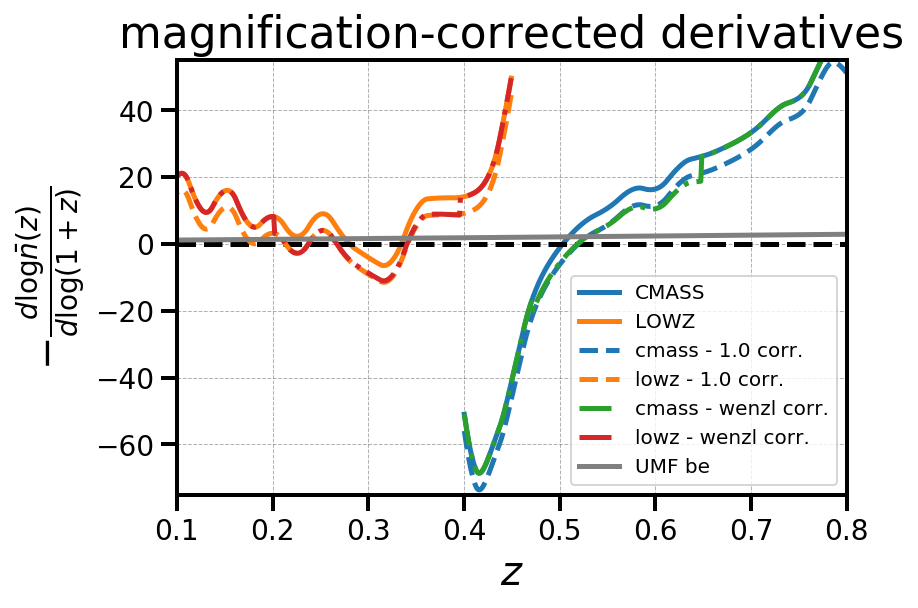

In [ ]:
plt.title("magnification-corrected derivatives")
plt.plot(zz[cmass_mask],-masked_dlogndz_CMASS_N,label='CMASS')
plt.plot(zz[lowz_mask],-masked_dlogndz_LOWZ_N,label='LOWZ')
plt.axhline(0.0,c='k',ls='--')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$-\frac{d\log \bar{n}(z)}{d\log(1+z)}$',fontsize=20)
plt.xlim(0.0,1.0)
plt.plot(zz[cmass_mask],-masked_dlogndz_CMASS_N+(5.0*1.0*redshift_fact)[cmass_mask],label='cmass - 1.0 corr.',c='C0',ls='--')
plt.plot(zz[lowz_mask],-masked_dlogndz_LOWZ_N+(5.0*1.0*redshift_fact)[lowz_mask],label='lowz - 1.0 corr.',c='C1',ls='--')
plt.plot(zz[cmass_mask],-masked_dlogndz_CMASS_N+(5.0*wenzl_mean_s_cmass(zz)*redshift_fact)[cmass_mask],label='cmass - wenzl corr.',ls='-.')
plt.plot(zz[lowz_mask],-masked_dlogndz_LOWZ_N+(5.0*wenzl_mean_s_lowz(zz)*redshift_fact)[lowz_mask],label='lowz - wenzl corr.',ls='-.')
plt.plot(zz,-UMF_be,color='gray',label='UMF be')
plt.legend(prop={'size': 10})
plt.ylim(-75,55)
plt.xlim(0.1,0.8)
plt.savefig('../plots/wenzl_corr_lowz_cmass_v1.png')
plt.savefig('../plots/wenzl_corr_lowz_cmass_v1.pdf')
plt.show()